<h2> Drawing Identification </h2>

<h3>Scurtă descriere</h3>

Acest proiect consta in definirea si antrenarea supervizata a unei retele neuronale ce este capabila sa identifice, dintr-o multime de 100 de figuri grafice diferite, categoria din care acestea fac parte.

Acest fisier consta in antrenarea si testarea retelei neuronale, precum si in salvarea modelului in format *.json pentru a putea fi folosit in javascript.

<h3> Pregătirea setului de date </h3>

Baza de date: Quick Draw dataset (https://github.com/googlecreativelab/quickdraw-dataset)

Structura:
<li>setul de date pentru antrenare ce cuprinde un număr de 320000 de figuri grafice;</li>
<li>setul de date pentru testare cu un număr de 80000 de figuri grafice;</li>

In [28]:
# Adaugare dependinte

import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [2]:
# Conectare la contul de drive (acesta contine setul de date si fisierul ce contine categoriile)

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Definirea dimensiunii unei figuri grafice

image_size = 28

In [4]:
# Definirea clasei utilizata pentru incarcarea setului de date

def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    # initializare variabile 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    # incarcare date din fiecare categorie
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    # Amestecare imagini din setul de date
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    # impartirea setului de date: train si test
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [5]:
# Definirea clasei utilizata pentru afisarea informatiilor legate de setul de date

def PrintDatasetInfo(x_train, y_train, x_test, y_test):
    print('Dimensiunea setului de date de antrenare (intrare):', x_train.shape)
    print('Dimensiunea setului de date de antrenare (etichete):', y_train.shape)
    print('Dimensiunea setului de date de testare (intrare):', x_test.shape)
    print('Dimensiunea setului de date de testare (etichete):', y_test.shape) 

In [15]:
# Incarcarea celor 100 de categorii

classes_path = '/content/drive/MyDrive/SRVA/classes.txt'

f = open(classes_path,"r")
classes = f.readlines()
f.close()

classes = [c.replace('\n','').replace(' ','_') for c in classes]

In [16]:
# Incarcare set de date

dataset_folder_path = '/content/drive/MyDrive/SRVA/drawing_dataset/'

x_train, y_train, x_test, y_test, class_names = load_data(dataset_folder_path)
num_classes = len(class_names)

PrintDatasetInfo(x_train, y_train, x_test, y_test)

Dimensiunea setului de date de antrenare (intrare): (320000, 784)
Dimensiunea setului de date de antrenare (etichete): (320000,)
Dimensiunea setului de date de testare (intrare): (80000, 784)
Dimensiunea setului de date de testare (etichete): (80000,)


In [17]:
# Redimensionare set de date

x_train = x_train.reshape(x_train.shape[0], image_size, image_size)
x_test = x_test.reshape(x_test.shape[0], image_size, image_size)

PrintDatasetInfo(x_train, y_train, x_test, y_test)

Dimensiunea setului de date de antrenare (intrare): (320000, 28, 28)
Dimensiunea setului de date de antrenare (etichete): (320000,)
Dimensiunea setului de date de testare (intrare): (80000, 28, 28)
Dimensiunea setului de date de testare (etichete): (80000,)


Train: X=(320000, 28, 28), y=(320000,)
Test: X=(80000, 28, 28), y=(80000,)


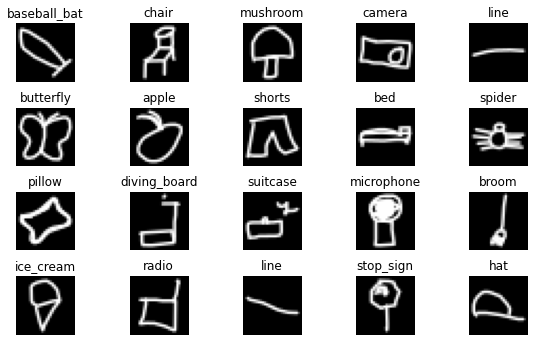

In [33]:
# Inspectare date

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

pyplot.figure(figsize=(8, 6))
for i in range(20):
    pyplot.subplot(5, 5, i+1)
    image = x_train[i]
    
    pyplot.imshow(image,cmap='gray')
    pyplot.title(class_names[int(y_train[i])])
    
    pyplot.axis('off')
pyplot.tight_layout(pad=1.0)
pyplot.show()

In [34]:
# normalizam imaginile (le aducem in tervalul [0,1])

x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# codificam clasese ca un vector de probabilitati
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

PrintDatasetInfo(x_train, y_train, x_test, y_test)

Dimensiunea setului de date de antrenare (intrare): (320000, 28, 28, 1)
Dimensiunea setului de date de antrenare (etichete): (320000, 100)
Dimensiunea setului de date de testare (intrare): (80000, 28, 28, 1)
Dimensiunea setului de date de testare (etichete): (80000, 100)


<h3> Arhitectura retelei </h3>

In [35]:
# Definim arhitectura retelei
model = keras.Sequential()
# Strat de convolutie cu 16 neuroni, filtru 3x3 si functia de activare relu
model.add(layers.Convolution2D(16, (3, 3), padding='same', input_shape=x_train.shape[1:], activation='relu'))
# Strat max-pooling de dimensiune 2x2
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Strat de convolutie cu 32 neuroni, filtru 3x3 si functia de activare relu
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
# Strat max-pooling de dimensiune 2x2
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Strat de convolutie cu 64 neuroni, filtru 3x3 si functia de activare relu
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
# Strat max-pooling de dimensiune 2x2
model.add(layers.MaxPooling2D(pool_size =(2,2)))
# Vectorizare
model.add(layers.Flatten())
# Strat ascuns cu 128 de neuroni si functia de activare relu
model.add(layers.Dense(128, activation='relu'))
# Strat de iesire neural cu 100 de neuroni (100 clase) si functia de activare sofmtax
model.add(layers.Dense(len(class_names), activation='softmax')) 

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0

In [36]:
# Definirea optimizatorului
opt = tf.optimizers.Adam()
# Compilam modelul 
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['top_k_categorical_accuracy'])

<h3> Antrenare retea </h3>

In [37]:
# Antrenare retea

model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

Epoch 1/5
1125/1125 - 325s - loss: 1.9193 - top_k_categorical_accuracy: 0.7808 - val_loss: 1.3713 - val_top_k_categorical_accuracy: 0.8779
Epoch 2/5
1125/1125 - 293s - loss: 1.2318 - top_k_categorical_accuracy: 0.8935 - val_loss: 1.1467 - val_top_k_categorical_accuracy: 0.9040
Epoch 3/5
1125/1125 - 284s - loss: 1.0747 - top_k_categorical_accuracy: 0.9106 - val_loss: 1.0657 - val_top_k_categorical_accuracy: 0.9122
Epoch 4/5
1125/1125 - 272s - loss: 0.9859 - top_k_categorical_accuracy: 0.9202 - val_loss: 1.0019 - val_top_k_categorical_accuracy: 0.9197
Epoch 5/5
1125/1125 - 273s - loss: 0.9282 - top_k_categorical_accuracy: 0.9262 - val_loss: 0.9643 - val_top_k_categorical_accuracy: 0.9241


<h3> Testare retea </h3>

In [38]:
# Testare retea

score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 92.14%


Predictions: ['basketball', 'butterfly', 'baseball', 'pizza', 'wheel']


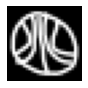

Predicted class: basketball


In [65]:
# Verificare predictie

%matplotlib inline 
idx = randint(0, len(x_test))
image = x_test[idx]

pyplot.figure(figsize=(8, 6))

pyplot.subplot(5, 5, 1)
pyplot.imshow(image.reshape(image_size, image_size),cmap='gray')   
pyplot.axis('off')
pyplot.tight_layout(pad=1.0)
pred = model.predict(np.expand_dims(image, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print('Predictions: '+ str(latex))
pyplot.show()
print('Predicted class: ' + str(latex[0]))

In [69]:
# Instalare biblioteca tensorflowjs
!pip install tensorflowjs 

<h3> Salvare model </h3>

In [71]:
# Salvare model
model.save('/content/drive/MyDrive/SRVA/model/keras.h5')

# Convertire model in format *.json
!tensorflowjs_converter --input_format keras /content/drive/MyDrive/SRVA/model/keras.h5 /content/drive/MyDrive/SRVA/model/

2021-02-05 20:52:02.714095: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
